In [1]:
# %pip install 'networkx<2.7'

In [2]:
# !pip install cdlib

In [3]:
import os
import heapq
import argparse
import threading
import multiprocessing
import sys
import queue


from __future__ import division
import math, time
from copy import deepcopy
import multiprocessing, json
from tqdm import tqdm
import heapq


#importing libraries that will be used
# import networkx as nx#for creating network
# import numpy as np
# import matplotlib.pyplot as plt#for plotting plots
# import random
# import time#claculating time
# import math
# from collections import Counter
# from itertools import permutations 
# from itertools import combinations

# from collections import defaultdict
# from scipy.io import mmread# to read dataset
# import pandas as pd



In [4]:
#importing libraries that will be used
import networkx as nx#for creating network
import numpy as np
import matplotlib.pyplot as plt#for plotting plots

import random
import time#claculating time
import math
from collections import Counter
from itertools import permutations 
from itertools import combinations

from collections import defaultdict
from scipy.io import mmread# to read dataset
import pandas as pd

# from cdlib import algorithms

In [5]:
def celf(graph, k):
    """
    Implementation of CELF algorithm for influence maximization in social networks
    
    Args:
    - graph: NetworkX graph object representing the social network
    - k: number of nodes to select
    
    Returns:
    - nodes: list of k nodes with the highest influence scores
    """
    # Initialize variables
    nodes = []
    heap = []
    marg_gains = {}

    # Calculate the marginal gain for each node
    for node in graph.nodes():
        # Run Monte Carlo simulations to estimate the influence of each node
        sim_res = linear_Threshold(graph, nodes + [node])
        marg_gains[node] = len(sim_res) - len(nodes)
        # Add the node to the heap with its marginal gain as key
        heapq.heappush(heap, (-marg_gains[node], node))

    # Select the k nodes with the highest influence scores
    while len(nodes) < k:
        # Get the node with the highest marginal gain
        _, node = heapq.heappop(heap)
        # Recalculate the marginal gain of the selected node
        sim_res = linear_Threshold(graph, nodes + [node])
        marg_gains[node] = len(sim_res) - len(nodes)
        # Add the node to the list of selected nodes
        nodes.append(node)
        # Update the heap with the new marginal gains
        for n in graph.neighbors(node):
            if n not in nodes:
                heapq.heappush(heap, (-marg_gains[n], n))

    return nodes


In [6]:
def Greedy(G,k):
    Dict={}
    mySet1=[]
    V=G.nodes()
    mySet1.clear()
    for i in range(k):
        for v in (V-mySet1):
            mySet1.append(v)
            a=linear_Threshold(G,mySet1)
            Dict[v]=len(a)#influence as value and current node as key
            mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
        Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
        Dict.clear()
        mySet1.append(Keymax)
#     print("Final seed set is:",mySet1,compute_Phi(G,mySet1,comm,k))
    return list(mySet1)


In [7]:
def read_txt(path):
  file1 = open(path,'r')
  sender = list()
  receiver = list()

  for i in file1.readlines():
    sender.append(int(i.split(' ')[0]))
    receiver.append(int(i.split(' ')[1].split('\n')[0]))
    
  df = pd.DataFrame(list(zip(sender,receiver)),columns =['source', 'target'])
  return df

In [8]:
def gmltotxt(filename):
    import networkx as nx
    import pandas as pd
    g = nx.read_gml('airlines.gml')
    nx.write_edgelist(g, 'edgelistFile.csv', delimiter=',')
    df = pd.read_csv('edgelistFile.csv')
    file = open("myfile.txt","w")
    for i in range(len(df)):
        x=df.iloc[i][0]
        y=df.iloc[i][1]
        file.write(str(x)+" "+str(y)+"\n")
    file.close()

In [9]:
def findresult(G,k,prevresult,lambdaa):
    
    comm_set_final=[]

    
    Greedy
    st=time.time()
    GreedyseedSet =Greedy(G,int(k))
    Greedytime=time.time()-st
    print('\n\n--------------- Greedy -------------------')
    Greedyresult=findcommunity(G,GreedyseedSet,k, comm_set_final,'Greedy')
    
    
    
#     #Single Degree Discount---Not Defined
#     st=time.time()
#     SingleDegreeSeedset = single_degree_discount(G,int(k))
#     SingleDegreetime=time.time()-st
#     print('\n\n--------------- Single Degree Discount -------------------')
#     SingleDegreeresult=findcommunity(G,SingleDegreeSeedset,k, comm_set_final,'SingleDegreeDiscount')
    
    
    #CELF
    st=time.time()
    CELFseedSet = celf(G,int(k))
    CELFtime=time.time()-st
    print('\n\n--------------- CELF -------------------')
    CELFresult=findcommunity(G,CELFseedSet,k, comm_set_final,'CELF')
    
    
    
#     #PMIA
#     st=time.time()
#     PMIAseedSet = run_PMIA(G,int(k))
#     PMIAtime=time.time()-st
#     print('\n\n--------------- PMIA -------------------')
#     PMIAresult=findcommunity(G,PMIAseedSet,k, comm_set_final,'PMIA')
    
    
    
#     #SIMPATH
#     st=time.time()
#     SIMPATHseedSet = run_SIMPATH(G,int(k))
#     SIMPATHtime=time.time()-st
#     print('\n\n--------------- SIMPATH -------------------')
#     SIMPATHresult=findcommunity(G,SIMPATHseedSet,k, comm_set_final,'SIMPATH')
    
    
    
    #PAGERANK
    st=time.time()
    pagerank = sorted(nx.pagerank(G).items(), key=lambda x: x[1], reverse=True)
    pagerank_seed = [node for node, value in pagerank[0:k]]
    PRtime=time.time()-st    
    print('\n\n--------------- PAGERANK -------------------')
    Pagerankresult=findcommunity(G,pagerank_seed,k, comm_set_final,'PageRank')

    #DEGREE
    st=time.time()
    degree = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    degree_seed = [node for node, value in degree[0:k]]
    Dtime=time.time()-st
    print('\n\n--------------- DEGREE -------------------')
    Degreeresult=findcommunity(G,degree_seed,k, comm_set_final,'Degree')


#     #HUB
    st=time.time()
    hub, authority = nx.hits(G)     
    hub  = sorted(hub.items(), key=lambda x: x[1], reverse=True)
    hub_seed = [node for node, value in hub[0:k]]
    Hubtime=time.time()-st
    print('\n\n--------------- HUB -------------------')
    Hubresult=findcommunity(G,hub_seed,k, comm_set_final,'Hub')

#     #AUTHORITY
    st=time.time()
    authority  = sorted(authority.items(), key=lambda x: x[1], reverse=True)
    authority_seed = [node for node, value in authority[0:k]]
    Atime=time.time()-st
    print('\n\n--------------- AUTHORITY -------------------')
    Authorityresult=findcommunity(G,authority_seed,k, comm_set_final,'Authority')

#     #NBKCORE
    st=time.time()
    # neighborhood coreness
    node2nbcore =  {node: np.sum([G.degree(nb) for nb in G.neighbors(node)]) for node in G.nodes() }
    nbkcore = sorted(node2nbcore.items(), key=lambda x: x[1], reverse=True)
    nbkcore_seed = [node for node, value in nbkcore[0:k]]
    N2time=time.time()-st
    print('\n\n--------------- neighborhood coreness -------------------')
    Neighbourresult=findcommunity(G,nbkcore_seed,k, comm_set_final,'Neighbourhood')
    

#     resultt=[DDR,Greedyresult,CELFresult,Pagerankresult,Degreeresult,Hubresult,Authorityresult,Neighbourresult]
#     resultt=[DDR,SingleDegreeresult,CELFresult,CELFPPresult,Pagerankresult,Degreeresult,Hubresult,Authorityresult,Neighbourresult]
#     resultt=[DDR,Greedyresult,CELFresult,Pagerankresult,Degreeresult,Hubresult,Authorityresult,Neighbourresult]

    resultt=[Greedyresult,CELFresult,Pagerankresult,Degreeresult,Neighbourresult,Hubresult]
    return resultt


In [10]:
def linear_Threshold(graph, seeds):
    influnces = seeds[:]
    queue = influnces[:]
    pre_node_record = defaultdict(float) 
#     print("Queue:",queue)
#     print("Influences:",influnces)
    while len(queue) != 0:
        node = queue.pop(0)
#         print("----------------------------------------------------------------------")
#         print("Take node:",node)
#         print("Neighbour:",graph[node])
        for element in graph[node]:
            if element not in influnces:
#                 print("Element:",element,"prerecored",pre_node_record[element])
                pre_node_record[element] = pre_node_record[element] + graph[node][element]['weight'] 
#                 print(pre_node_record[element])
                if pre_node_record[element] >= graph.nodes[element]['thres']:
#                     print(">>>>>>>>>>>>>>>>>>node influeced:",element)
                    influnces.append(element)
                    queue.append(element)
#     influnce_num = len(influnces)
#     print("Seed set:",seeds,"Activated nodes:",influnces)
    return influnces
# linear_Threshold(GG,[45,29])

In [11]:

# obj=TBCD_mine()
# perc=[20,40,60,80]
# filename='200_0'
# print("hello")
# obj.execute_TBCD_txt(filename,perc)

In [12]:
def findk(i):#dynamic calculation of k according the percentage of current dataset
  k=(0.01*i)
  if(i==0):
    k=1
  if(k>int(k)):
   k=int(k)+1
  return k

In [13]:
def displayresult(result,itr,perc):
    print("\n\n\n\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

    linestylee=['dashdot','dashed','dotted','-', '--', ':','-.' ]
    
    markerss = ['o','v','s','*','+','x','D','d','X','P']
#     descriptions = ['circle', 'triangle_down','square','star', 'plus','x','diamond', 'thin_diamond','x (filled)','plus (filled)']
    communitiesITR=[]
    Name=[]
    activatednodesITR=[]
    totalcomm=[]
#     print(itr,result)
    
    for i in result:
        for j in range(len(result[i])):
            Name.append(result[i][j]['Name'])
        break
#     print(Name)
    
#     for i in result:
# #         print(result[i])
#         for j in range(len(result[i])):
#             totalcomm.append(result[i][j]['Total communitites'])
#             break
#     print("Total communitites:",totalcomm)
    
    for i in result:
        active=[]
#         comm=[]
        for j in range(len(result[i])):
            active.append(result[i][j]['length of activated nodes'])
#             comm.append(result[i][j]['number of communities'])
        activatednodesITR.append(active)
#         communitiesITR.append(comm)
#     print("Activated nodes:",activatednodesITR)
#     print("Communities:",communitiesITR)
        
    
        
#     print("hello");
    
    plt.xlabel("Percentage")
    plt.ylabel("Activated nodes")
    plt.title("Activated nodes - LFR_1000_0.0 - Greedy - lemda=0.5 - Degree")
    for i in range(len(activatednodesITR[0])):
        plt.plot(perc,[pt[i] for pt in activatednodesITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
    plt.legend()
    plt.show()
    
    
#     plt.xlabel("Percentage")
#     plt.ylabel("No of community")
#     plt.title("Communitites - LFR_1000_0.0 - Greedy - lemda=0.5 - Degree")
#     for i in range(len(communitiesITR[0])):
#         plt.plot(perc,[pt[i] for pt in communitiesITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
# #     plt.plot(perc,totalcomm,label='Total community',linestyle='%s'%linestylee[-1],marker='%s'%markerss[-1])
#     plt.legend()
#     plt.show()
    

In [14]:
def findcommunity(G,seedset,k, comm,algoname):
#     print ("Communities formed: ",len(comm))
    activated = linear_Threshold(G, seedset)
    noofcommunity=0
    for com in comm:
        if any(x in activated for x in com):
            noofcommunity=noofcommunity+1
#     print("Community we got:",noofcommunity)
    upperBound_dict = {
        'Name':algoname,
        'k_nodes': k,
#         'Total communitites':len(comm),
#         'number of communities':noofcommunity,
        'length of activated nodes': len(activated),
        
        # 'length of communities': len(community_df['Unnamed: 1'].unique())
    }
    print(upperBound_dict)
    return upperBound_dict

In [15]:
def makeExcel(result,itr,perc):
    timeITR=[]
    Name=[]
    activatednodesITR=[]
    for i in result:
        for j in range(len(result[i])):
            Name.append(result[i][j]['Name'])
        break
    for i in result:
        active=[]
        timee=[]
        for j in range(len(result[i])):
            active.append(result[i][j]['length of activated nodes'])
            timee.append(result[i][j]['number of communities'])
        activatednodesITR.append(active)
        timeITR.append(timee)
    df=pd.DataFrame()
    time="Community"
    for i in range(len(timeITR)):
        timestr=time+"_"+str(perc[i])+"_"+str(perc[i])+"%"
        df[timestr]=timeITR[i]
#     print("After name",df)
    ICnodes="Activated_Nodes"
    for i in range(len(activatednodesITR)):
        ICnodesstr=ICnodes+"_"+str(perc[i])+"_"+str(perc[i])+"%"
        df[ICnodesstr]=activatednodesITR[i]
    df.insert(0,"Name of Algorithm",Name)
    return df


In [16]:
class TBCD_mine(object):
    """
        tree based community detection
    """

    def __init__(self, filename=None, g=nx.Graph(), ttl=float('inf'), obs=7, path="",
                 start=None, end=None, level_max = 6, window_size = 20, theta = 0.5,
                 dataset = None, edge_list = None, comm_list = None,window_ratio = 0.10):
        """
            Constructor
            :param g: networkx graph
            :param ttl: edge time to live (days)
            :param obs: observation window (days)
            :param path: Path where generate the results and find the edge file
            :param start: starting date
            :param end: ending date
        """
        print("initialization")
        self.path = path
        self.graph = g
        self.removed = 0
        self.added = 0
        self.filename = filename
        self.start = start
        self.end = end
        self.obs = obs
        self.communities = {}
        self.intra_conn = {}
        self.inter_conn = {}
        self.select = {}
        self.cluster_head = set()
        self.cluster_h = {}
        self.level = {}
        self.occurence = {}
        self.level_max = level_max
        self.w_temp = 0
        self.window_size = window_size
        self.theta = theta
        self.dataset = ""
        self.edge_list = ""
        self.comm_list = ""
        self.ground_truth_comm = {}
        self.precision = -1
        self.recall = -1
        self.nmi = -1
        self.f_measure = -1
        self.purity = -1
        self.ari = -1
        self.entropy = -1
        self.modularity = -1
        self.coverage = -1
        self.external_density = -1
        self.average_isolability = -1
        self.mat_file_adj = ""
        self.mat_file_label = ""
        self.row = 1
        self.result_array = []
        self.window_ratio = window_ratio


    
        
    def calldiverified(self):
        print(self.graph)
        return 1,3
    

    def execute_TBCD_txt(self,file_name,perc,kvalues):
        """
            Execute tree based community detection algorithm from static dataset
        """

        # print("reading static edge list with file name : "+str(file_name))
#         self.edge_list = './datasets_txt/' + file_name + '_edge_list.txt'
#         self.comm_list = './datasets_txt/' + file_name + '_comm_list.txt'
        self.edge_list = file_name + '_edge_list.txt'
#         self.comm_list =  file_name + '_comm_list.txt'
    
        edge_list = open(self.edge_list)
#         print("counting edges to set window size")
        window_counter = 0
        count = 0
        for l in edge_list:
            count += 1
        print("Count:",count,"Window ratio:",self.window_ratio)
        
        self.window_size = int(count*self.window_ratio)
        print("Window size:",self.window_size)
        
        self.graph = nx.Graph()
        # print(self.graph)
        
#       print("before reading edge list text file")
        no_nodes = 0
        w = 0
        edge_list = open(self.edge_list)
        R_seed=[]
        seedSet=[]
        pagerank=[]
        G = nx.DiGraph()
#         MultiDiGraph
        # print("------------------------------------------------------------------------------------------")
        
        print(count)
        itr=[]
        for i in range(len(perc)):
            vv=int((perc[i]/100)*count)
            itr.append(vv)
        print(itr)
        totalnodes=0
        resultt={}
        
        for l in edge_list:
#             print(l)
            totalnodes=totalnodes+1
            l = l.split(" ")
            s=int(l[0])
            t=int(l[1])
            value = round(random.uniform(0.01,1.0),2)
            G.add_edge(s,t,weight=value)
            G.nodes[s]['thres']=(G.in_degree(s)/2)
            G.nodes[t]['thres']=(G.in_degree(t)/2)
            k=int(findk(len(G.nodes)))
            
            self.added += 1
            e = {}
            x = int(l[0])
            y = int(l[1])

            w += 1
            # print("w:",w," window size:",self.window_size)
#             print(itr,totalnodes)
            if w == self.window_size or totalnodes==count:
                print("************************************************************************** at",totalnodes)
                window_counter += 1  
#                 print("Window sizeee",totalnodes)
#                 self.TBCD_dissol()
#                 seedset,activatednodes=self.calldiverified()
#                 self.all_metric()
                w = 0
#                 findresult(G,k,comm_set_final):
            
            if totalnodes in itr:
                print("_______________________________________________________________________________________________")
                print("Get result at edge:",totalnodes)
                w = 0
#                 print("_______________________________________________________________________________________________")
                
                print("Nodes:",len(G.nodes()))
                print("Edges:",len(G.edges()))
                
                print("Get result at node:",totalnodes)
                prevresult=[]
                lambdaa=0.1
                for kval in kvalues:
                    print("\n\n\n---------------------At seed set size:",kval)
                    resultt[kval]=findresult(G,kval,prevresult,lambdaa)
                displayresult(resultt,itr,kvalues)
                dff = makeExcel(resultt,itr,kvalues)
                dff.to_excel('Outputt.xlsx')
                processResults('LFR_500_0.8_l0.1_power.xlsx')
                
#         displayresult(resultt,itr,kvalues)
#         dff = makeExcel(resultt,itr,kvalues)
        return dff

            
    def checkingg(self):
        print("666")
        
# obj=TBCD_mine()
# perc=[20,40,60,80,100]
# filename='LFR_500_0.0'
# obj.execute_TBCD_txt(filename,perc)

In [17]:
# obj=TBCD_mine()
# perc=[20,40,60,80,100]
# filename='LFR_500_0.0'
# obj.execute_TBCD_txt(filename,perc)

In [18]:
print("hello.")

hello.


initialization
Count: 986 Window ratio: 0.1
Window size: 98
986
[986]
************************************************************************** at 98
************************************************************************** at 196
************************************************************************** at 294
************************************************************************** at 392
************************************************************************** at 490
************************************************************************** at 588
************************************************************************** at 686
************************************************************************** at 784
************************************************************************** at 882
************************************************************************** at 980
************************************************************************** at 986
_____________________________

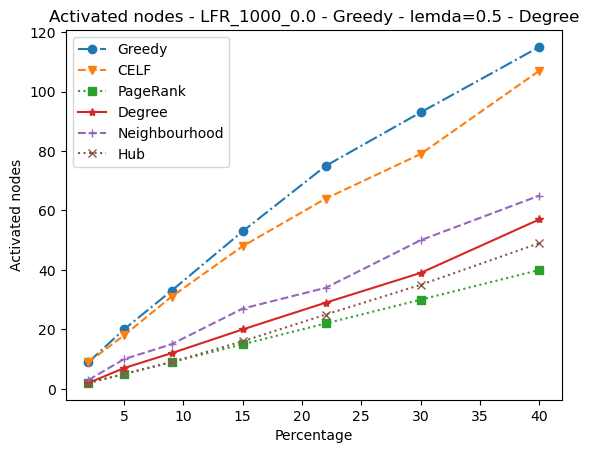

KeyError: 'number of communities'

In [19]:
def executeDiv():
    result_df=pd.DataFrame()
    for i in range(1):
        obj=TBCD_mine()
        perc=[100]
        kvalues=[2,5,9,15,22,30,40]
        filename='LFR_500_0.8'
#         filename='dolphin'
        dff=obj.execute_TBCD_txt(filename,perc,kvalues)
        dff2=result_df
        result_df=dff
        result_df = dff2.append(dff,ignore_index = True)
        result_df.to_excel('Outputt.xlsx')
def processResults(filename):
    df = pd.read_excel('Outputt.xlsx')
    print(df.shape)
#     print(df.head(8))
    TBCD = df.loc[df['Name of Algorithm']=='TBCD']
    Greedy = df.loc[df['Name of Algorithm']=='Greedy']
    CELF = df.loc[df['Name of Algorithm']=='CELF']
    PMIA = df.loc[df['Name of Algorithm']=='PMIA']
    SIMPATH = df.loc[df['Name of Algorithm']=='SIMPATH']
    DEGREE = df.loc[df['Name of Algorithm']=='Degree']
    PAGERANK = df.loc[df['Name of Algorithm']=='PageRank']
    
    cols= df.columns

    ddris = pd.DataFrame(TBCD[cols].mean(),columns = ['TBCD'])
    greedy = pd.DataFrame(Greedy[cols].mean(),columns = ['Greedy'])
    celf = pd.DataFrame(CELF[cols].mean(),columns = ['CELF'])
    pmia = pd.DataFrame(PMIA[cols].mean(),columns = ['PMIA'])
    simpath = pd.DataFrame(SIMPATH[cols].mean(),columns = ['SIMPATH'])
    degree = pd.DataFrame(DEGREE[cols].mean(),columns = ['DEGREE'])
    pagerank = pd.DataFrame(PAGERANK[cols].mean(),columns = ['PageRank'])
    
    
#     resultant = pd.concat([ddris, greedy,celf,pmia,simpath,degree,pagerank], axis='columns')
    resultant = pd.concat([ddris,celf,pmia,simpath,degree,pagerank], axis='columns')

#     resultant = pd.concat([ddris,pmia,simpath,degree,pagerank], axis='columns')
#     print("Resultant:",resultant)
    
    result=resultant.iloc[1:]
#     print("Result:",result)
    
    result.to_excel(filename)
    
    
executeDiv()
# processResults()